<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
XGBoost for Regression 
</p>

In [2]:
# Libraries for data manipulation and visualization
import numpy as np                               # For numerical operations
import pandas as pd                              # For data manipulation
import matplotlib.pyplot as plt                  # For plotting
import seaborn as sns                            # For advanced data visualization

# Libraries for model building and evaluation
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (                     # For model evaluation metrics
    mean_squared_error, 
    r2_score, 
    mean_absolute_percentage_error, 
    median_absolute_error
)

# XGBoost library
import xgboost as xgb                             # For XGBoost Regressor
from xgboost import XGBRegressor

# ================================
# Set Seed for Reproducibility
# ================================
RANDOM_STATE = 50
np.random.seed(RANDOM_STATE)

In [3]:
# Define the path to the dataset
dataset_path = '../../all_data_files/cleaned_dataset_per_device.csv'

# Load the dataset
try:
    df = pd.read_csv(dataset_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"File not found at the specified path: {dataset_path}")
    import sys
    sys.exit()

# Display dataset information
print("\nDataset Information:")
df.info()
print("\nFirst Five Rows of the Dataset:")
display(df.head())

Dataset loaded successfully.

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554505 entries, 0 to 554504
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   time         554505 non-null  object 
 1   device_id    554505 non-null  object 
 2   co2          554505 non-null  float64
 3   humidity     554505 non-null  float64
 4   pm25         554505 non-null  float64
 5   pressure     554505 non-null  float64
 6   temperature  554505 non-null  float64
 7   rssi         554505 non-null  float64
 8   snr          554505 non-null  float64
 9   SF           554505 non-null  int64  
 10  frequency    554505 non-null  float64
 11  f_count      554505 non-null  float64
 12  p_count      554505 non-null  float64
 13  toa          554505 non-null  float64
 14  distance     554505 non-null  int64  
 15  c_walls      554505 non-null  int64  
 16  w_walls      554505 non-null  int64  
 17  exp_pl       554

,time,device_id,co2,humidity,pm25,pressure,temperature,rssi,snr,SF,frequency,f_count,p_count,toa,distance,c_walls,w_walls,exp_pl,n_power,esp
0,2024-09-26 11:02:08.387851+00:00,ED0,539.0,49.34,0.39,299.69,24.57,-48.0,8.5,9,867.5,82.0,109.0,0.246784,10,0,0,65.4,-57.073822,-48.573822
1,2024-09-26 11:03:08.309590+00:00,ED0,540.0,49.33,0.80,299.77,24.59,-48.0,12.8,8,867.3,83.0,110.0,0.133632,10,0,0,65.4,-61.022142,-48.222142
2,2024-09-26 11:04:08.368448+00:00,ED0,537.0,49.28,0.71,299.70,24.62,-48.0,8.0,8,868.5,84.0,111.0,0.133632,10,0,0,65.4,-56.638920,-48.638920
3,2024-09-26 11:05:08.405529+00:00,ED0,537.0,49.34,0.56,299.69,24.63,-49.0,11.0,8,867.9,85.0,112.0,0.133632,10,0,0,66.4,-60.331956,-49.331956
4,2024-09-26 11:06:08.455112+00:00,ED0,534.0,49.28,0.60,299.73,24.64,-46.0,9.2,8,867.5,86.0,113.0,0.133632,10,0,0,63.4,-55.693058,-46.493058


In [4]:
# Define feature columns and target
feature_columns = [
    'distance', 'frequency', 'c_walls', 'w_walls', 
    'co2', 'humidity', 'pm25', 'pressure', 
    'temperature', 'snr'
]
target_column = 'exp_pl'

# Verify that all required columns exist
missing_columns = set(feature_columns + [target_column]) - set(df.columns)
if missing_columns:
    raise ValueError(f"The following required columns are missing in the dataset: {missing_columns}")

# Extract features and target
all_features = df[feature_columns].values
PL_all = df[target_column].values

# Perform train-test split (80-20 split)
X_train_all, X_test_all, PL_train_all, PL_test_all = train_test_split(
    all_features, PL_all, test_size=0.2, random_state=RANDOM_STATE
)

print("Train-test split completed.")

Train-test split completed.


In [5]:
# Define a single set of hyperparameters manually
hyperparameters = {
    'max_depth': 3,
    'n_estimators': 200,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.1,      
    'colsample_bylevel': 0.1,      
    'colsample_bynode': 0.1, 
    'min_child_weight': 10,
    'gamma': 0.1,
    'reg_alpha': 1,
    'reg_lambda': 1,
    'objective': 'reg:squarederror',
    'random_state': RANDOM_STATE,
    'n_jobs': -1
}

print(f"Training XGBoost model with hyperparameters: {hyperparameters} ..... ")

# Initialize the XGBoost Regressor with the specified hyperparameters
xgb_model = xgb.XGBRegressor(**hyperparameters)

# Train the model
xgb_model.fit(X_train_all, PL_train_all)

print("\n Model training completed!")

Training XGBoost model with hyperparameters: {'max_depth': 3, 'n_estimators': 200, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.1, 'colsample_bylevel': 0.1, 'colsample_bynode': 0.1, 'min_child_weight': 10, 'gamma': 0.1, 'reg_alpha': 1, 'reg_lambda': 1, 'objective': 'reg:squarederror', 'random_state': 50, 'n_jobs': -1} ..... 

 Model training completed!


In [6]:
# Initialize a list to store evaluation metrics for the model
evaluation_metrics = []

print("\nEvaluating the trained XGBoost model...")

# Make predictions on the training set
PL_train_pred = xgb_model.predict(X_train_all)
# Make predictions on the test set
PL_test_pred = xgb_model.predict(X_test_all)

# Calculate metrics
train_mse = mean_squared_error(PL_train_all, PL_train_pred)
test_mse = mean_squared_error(PL_test_all, PL_test_pred)
train_r2 = r2_score(PL_train_all, PL_train_pred)
test_r2 = r2_score(PL_test_all, PL_test_pred)
test_rmse = np.sqrt(test_mse)
test_mape = mean_absolute_percentage_error(PL_test_all, PL_test_pred)
test_median_ae = median_absolute_error(PL_test_all, PL_test_pred)

# Append metrics to the list
evaluation_metrics.append({
    'Model': 'XGBoost',
    'Training Loss (MSE)': train_mse,
    'Test Loss (MSE)': test_mse,
    'Test RMSE': test_rmse,
    'R² Score': test_r2,
    'Test MAPE (%)': test_mape * 100,
    'Test Median AE': test_median_ae
})

print(f" \n Model Evaluation Metrics:")
display(pd.DataFrame(evaluation_metrics))


Evaluating the trained XGBoost model...
 
 Model Evaluation Metrics:


,Model,Training Loss (MSE),Test Loss (MSE),Test RMSE,R² Score,Test MAPE (%),Test Median AE
0,XGBoost,45.317158,45.697441,6.759988,0.872695,5.580977,3.847803


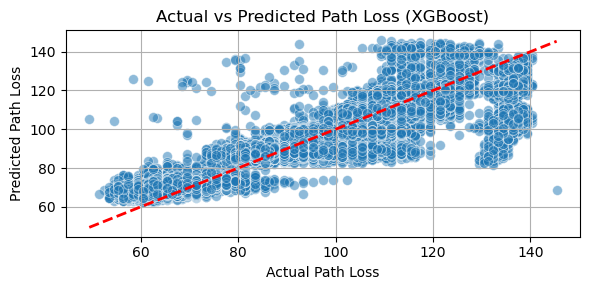

In [7]:
# Plot Actual vs Predicted Path Loss
plt.figure(figsize=(6, 3))
sns.scatterplot(x=PL_test_all, y=PL_test_pred, alpha=0.5, edgecolor='w', s=50)
plt.plot([PL_test_all.min(), PL_test_all.max()], [PL_test_all.min(), PL_test_all.max()], 'r--', lw=2)
plt.xlabel('Actual Path Loss')
plt.ylabel('Predicted Path Loss')
plt.title('Actual vs Predicted Path Loss (XGBoost)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# Define the number of folds for cross-validation
n_folds = 5

# Initialize KFold with consistent RANDOM_STATE
kf = KFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_STATE)

# Initialize a list to store evaluation metrics for each fold
cv_results = []

print("\nPerforming Manual K-Fold Cross-Validation...\n")

# Iterate over each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_all), 1):
    print(f"Fold {fold}:")

    # Split the data for the current fold
    X_train_fold, X_val_fold = X_train_all[train_idx], X_train_all[val_idx]
    PL_train_fold, PL_val_fold = PL_train_all[train_idx], PL_train_all[val_idx]
    
    # Initialize the XGBoost Regressor with the specified hyperparameters
    xgb_model = xgb.XGBRegressor(**hyperparameters)
    
    # Train the model on the current fold
    xgb_model.fit(X_train_fold, PL_train_fold)
    
    # Make predictions on the validation set
    PL_val_pred = xgb_model.predict(X_val_fold)
    
    # Calculate evaluation metrics
    val_mse = mean_squared_error(PL_val_fold, PL_val_pred)
    val_rmse = np.sqrt(val_mse)
    val_r2 = r2_score(PL_val_fold, PL_val_pred)
    val_mape = mean_absolute_percentage_error(PL_val_fold, PL_val_pred)
    val_median_ae = median_absolute_error(PL_val_fold, PL_val_pred)
    
    # Append metrics to the cv_results list
    cv_results.append({
        'Fold': fold,
        'Validation Loss (MSE)': round(val_mse, 4),
        'Validation RMSE': round(val_rmse, 4),
        'R² Score': round(val_r2, 4),
        'Validation MAPE (%)': round(val_mape * 100, 2),
        'Validation Median AE': round(val_median_ae, 4)
    })
    
    # Print metrics for the current fold
    print(f"  MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}, "
          f"MAPE: {val_mape*100:.2f}%, Median AE: {val_median_ae:.4f}\n")

# Convert the list of dictionaries to a DataFrame for better visualization
cv_results_df = pd.DataFrame(cv_results)

print("K-Fold Cross-Validation Results:")
display(cv_results_df)

# Calculate summary statistics
cv_summary = cv_results_df.agg(['mean', 'std']).round(4).reset_index()
cv_summary.rename(columns={'index': 'Metric'}, inplace=True)
print("\nCross-Validation Summary:")
display(cv_summary)


Performing Manual K-Fold Cross-Validation...

Fold 1:
  MSE: 45.3127, RMSE: 6.7315, R²: 0.8732, MAPE: 5.57%, Median AE: 3.8675

Fold 2:
  MSE: 46.1816, RMSE: 6.7957, R²: 0.8711, MAPE: 5.59%, Median AE: 3.8734

Fold 3:
  MSE: 45.1508, RMSE: 6.7194, R²: 0.8738, MAPE: 5.59%, Median AE: 3.8672

Fold 4:
  MSE: 45.1949, RMSE: 6.7227, R²: 0.8734, MAPE: 5.56%, Median AE: 3.8498

Fold 5:
  MSE: 44.8806, RMSE: 6.6993, R²: 0.8744, MAPE: 5.55%, Median AE: 3.8511

K-Fold Cross-Validation Results:


,Fold,Validation Loss (MSE),Validation RMSE,R² Score,Validation MAPE (%),Validation Median AE
0,1,45.3127,6.7315,0.8732,5.57,3.8675
1,2,46.1816,6.7957,0.8711,5.59,3.8734
2,3,45.1508,6.7194,0.8738,5.59,3.8672
3,4,45.1949,6.7227,0.8734,5.56,3.8498
4,5,44.8806,6.6993,0.8744,5.55,3.8511



Cross-Validation Summary:


,Metric,Fold,Validation Loss (MSE),Validation RMSE,R² Score,Validation MAPE (%),Validation Median AE
0,mean,3.0000,45.3441,6.7337,0.8732,5.5720,3.8618
1,std,1.5811,0.4942,0.0366,0.0012,0.0179,0.0107
